## Задание 1

Какова вероятность отправиться на прогулку, если идёт дождь, при наличии следующих наблюдений?

```
data = [
        ('солнечно', True),
        ('снег', False),
        ('облачно', False),
        ('дождь', False),
        ('солнечно', True),
        ('снег', False),
        ('облачно', True),
        ('снег', False),
        ('солнечно', False),
        ('облачно', True),
        ('снег', True),
        ('солнечно', True),
        ('дождь', False),
        ('дождь', True),
        ('облачно', True),
]

***Решение:***

1) Рассмотрим следующие гипотезы:

    1. $H_1 =$ будет *солнечнно*;

    2. $H_2 =$ будет *снег*;

    3. $H_3 =$ будет *облачно*;

    4. $H_4 =$ будет *дождь*.

    Данные гипотезы образуют полную группу.

2) Вероятность возникновения гипотез (априорная вероятность гипотез $H_i, i = \overline{1, 4}$):

    1. $P(H_1) = \frac{4}{15}$;

    2. $P(H_2) = \frac{4}{15}$;

    3. $P(H_3) = \frac{4}{15}$;
    
    4. $P(H_4) = \frac{3}{15}$.

    Проверка: $\sum\limits_{i=1}^4 P(H_i) = 1$

3) Пусть зависимое событие $A$ – отправиться на прогулку. Оно может наступить, если наступит одна из гипотез $H_i, i = \overline{1, 4}$. Вероятность пойти гулять при наступлении гипотезы $H_i$:

    1. при $i = 1: P(A|H_1) = \frac{3}{4}$;

    2. при $i = 2: P(A|H_2) = \frac{1}{4}$;

    3. при $i = 3: P(A|H_3) = \frac{3}{4}$;

    4. при $i = 4: P(A|H_4) = \frac{1}{3}$.

4) Значит, полная вероятность события $A$ равна: $P(A) = \sum\limits_{i=1}^4 P(H_i) \cdot P(A|H_i) = \frac{4}{15} \cdot \frac{3}{4} + \frac{4}{15} \cdot \frac{1}{4} + \frac{4}{15} \cdot \frac{3}{4} + \frac{3}{15} \cdot \frac{1}{3} = \frac{8}{15}$.

5) Получается, по формулам Байеса, вероятность дождя при походе на прогулку: $P(H_4|A) = \frac{P(H_4) \cdot P(A|H_4)}{P(A)} = \frac{1}{8}$.


## Задание 2

- загрузите датасет для регрессии, проведите предобработку, выделите целевой признак и предикторы, разбейте данные на обучающую и тестовую выборку;
- Масштабируйте числовые признаки
- В случае дисбаланса проведите балансировку
- решите задачу классификации на ваших данных с использованием рассмотренных моделей sklearn: knn, NB, Logistic Regression, SVM. Не забудьте подобрать гиперпараметры.
- вычислите значения метрик Accuracy, Precision, Recall, F1, ROC AUC score

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression


In [3]:
table = pd.read_csv("../data/neo_task.csv")
table.head(5)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,3561024.0,(2011 GZ2),0.016016,0.035813,56014.078517,1.024333e+06,26.1,False
1,54016766.0,(2020 HT6),0.030518,0.068240,7864.348060,3.268186e+07,24.7,False
2,3746620.0,(2016 ED156),0.055533,0.124177,55257.544508,6.538636e+07,23.4,False
3,3633054.0,(2013 FD8),0.019256,0.043057,41531.404722,1.260796e+07,25.7,False
4,3742124.0,(2016 CW31),0.139494,0.311918,67639.394481,7.130590e+07,21.4,False


In [4]:
table.drop(columns=['id', 'name'], axis=1, inplace=True)
table.head(5)

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.035813,56014.078517,1.024333e+06,26.1,False
1,0.030518,0.068240,7864.348060,3.268186e+07,24.7,False
2,0.055533,0.124177,55257.544508,6.538636e+07,23.4,False
3,0.019256,0.043057,41531.404722,1.260796e+07,25.7,False
4,0.139494,0.311918,67639.394481,7.130590e+07,21.4,False


In [5]:
null_columns = []
for i in table.columns:
    if len(table[table[i].isnull()]) > 0:
        null_columns.append(i)
print(null_columns)

['est_diameter_max', 'relative_velocity', 'absolute_magnitude']


In [6]:
def fill_empty_cell(column_name, df):
    if df.dtypes[column_name] == "float64":
        df[column_name] = df[column_name].fillna(df[column_name].mean())
    elif df.dtypes[column_name] == "int64":
        df[column_name] = df[column_name].fillna(df[column_name].median())
    else:
        df[column_name] = df[column_name].fillna(df[column_name].mode())


for name in null_columns:
    fill_empty_cell(name, table)

In [7]:
for i in table.columns:
    if len(table[table[i].isnull()]) > 0:
        print(f"В столбце {i} есть пустые элементы")

In [8]:
table.to_csv('../data/neo_task_compleated.csv', index=False) 

In [9]:
table.groupby(['hazardous'])['hazardous'].count()
# дисбаланс классов явно присутствует!!!

hazardous
False    81996
True      8840
Name: hazardous, dtype: int64

In [10]:
X = np.array(table.drop(columns=['hazardous'], axis=1))
y = np.array(table['hazardous'])

In [11]:
# масштабирование столбиков (очень большой разлет значений)
means, stds = X.mean(axis=0), X.std(axis=0)
X = (X - means) / stds
print(X[:3])
X

[[-0.37324117 -0.37376222  0.31519076 -1.61248863  0.8925783 ]
 [-0.32466019 -0.32510641 -1.59424649 -0.19616596  0.40698129]
 [-0.24085864 -0.24117577  0.28518947  1.26699715 -0.04393023]]


array([[-0.37324117, -0.37376222,  0.31519076, -1.61248863,  0.8925783 ],
       [-0.32466019, -0.32510641, -1.59424649, -0.19616596,  0.40698129],
       [-0.24085864, -0.24117577,  0.28518947,  1.26699715, -0.04393023],
       ...,
       [-0.3095138 , -0.30993669,  2.70546748,  0.78952589,  0.30292478],
       [-0.27912096, -0.27949703, -0.09131589, -0.45265798,  0.12949728],
       [-0.14401813, -0.14418609,  1.24732844, -0.03375455, -0.35956829]])

In [12]:
# решение проблемы дисбаланса классов
smt = SMOTE()
X, y = smt.fit_resample(X, y)
print(X.shape, y.shape)

(163992, 5) (163992,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

**1. Метод k-ближайших соседей + метрики**

In [14]:
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2).fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9061343957071426

In [15]:
confusion_matrix(y_test, y_pred)

array([[20206,  4393],
       [  225, 24374]], dtype=int64)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.82      0.90     24599
        True       0.85      0.99      0.91     24599

    accuracy                           0.91     49198
   macro avg       0.92      0.91      0.91     49198
weighted avg       0.92      0.91      0.91     49198



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# display = RocCurveDisplay(
#     fpr=fpr, 
#     tpr=tpr, 
#     roc_auc=roc_auc
# )

# display.plot()

# plt.show()

RocCurveDisplay.from_estimator(knn, X_test, y_test)

**2. Наивный Байесовский классификатор + метрики**

In [24]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.76      0.82     24599
        True       0.79      0.91      0.84     24599

    accuracy                           0.83     49198
   macro avg       0.84      0.83      0.83     49198
weighted avg       0.84      0.83      0.83     49198



In [25]:
confusion_matrix(y_test, y_pred)

array([[18587,  6012],
       [ 2310, 22289]], dtype=int64)

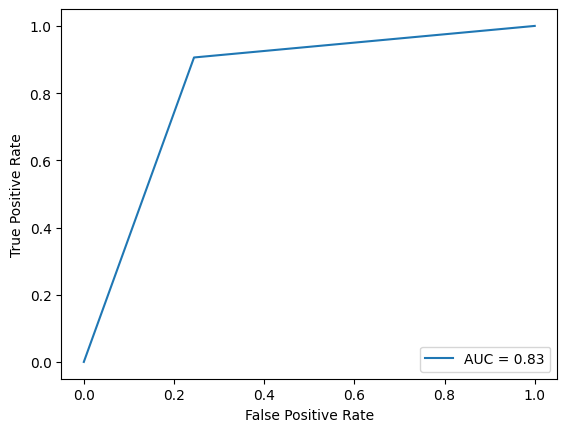

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(
    fpr=fpr, 
    tpr=tpr, 
    roc_auc=roc_auc
)

display.plot()

plt.show()

In [28]:
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.76      0.83     24599
        True       0.80      0.93      0.86     24599

    accuracy                           0.85     49198
   macro avg       0.86      0.85      0.85     49198
weighted avg       0.86      0.85      0.85     49198



In [29]:
confusion_matrix(y_test, y_pred)

array([[18776,  5823],
       [ 1702, 22897]], dtype=int64)

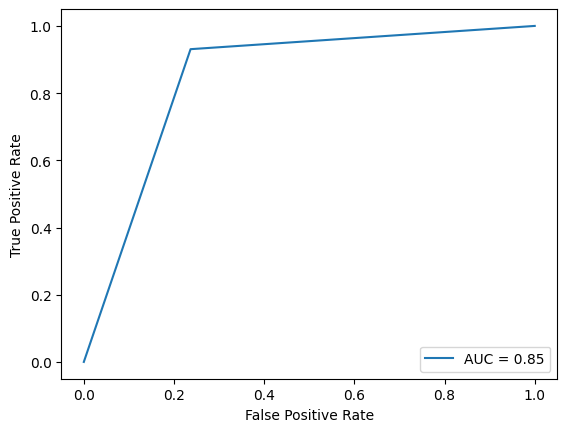

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(
    fpr=fpr, 
    tpr=tpr, 
    roc_auc=roc_auc
)

display.plot()

plt.show()

In [32]:
# clf = svm.SVC()
# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(
    fpr=fpr, 
    tpr=tpr, 
    roc_auc=roc_auc
)

display.plot()

plt.show()

## Задание 3
* Самостоятельно реализуйте метрики Accuracy, Precision, Recall, F1
* Самостоятельно реализуйте kNN и Naive Bayes

## Дополнительные баллы

* Самостоятельно реализуйте SVM с возможностью выбирать ядро.